# Python SAFT Equation of State

The following notebook will run through some tests and demonstration of how the python SAFT package could be used.

In [3]:
import saftgamma as saft
from dervarnp import *
import matplotlib.pyplot as plt

## Setting up

Object-oriented programming is used for convenience of coding and using different functions. The super classes used here includes:
1. `class System()`
2. `class MieGroup()`
3. `class Component()`

Other classes inherit properties from 1 or more of these 3 classes. These classes should contain all the high level functions, such as defining what are the state properties (`System.temperature`, `System.volume`), getting derivatives (`System.dV()`, `System.dT()`) and algorithms used to find properties (`System.critical_point()`, `System.get_kappa()`, `Component.thdebroglie()`, `Component.cp_int()`).

In the derived classes from System, the main functions that must be defined (in order to use the System classes' algorithms) are `System.helmholtz()`, `System.helmholtz_residual()`, `System.helmholtz_ideal()`. For instance, the class for SAFT-VR Mie equation of state is `class SAFTVRSystem(System)`, where the relevant functions are created to help in calculating the helmholtz energy. By defining the three functions, the `SAFTVRSystem` class can now use the pre-defined algorithms provided in the `System` super class to find thermodynamic properties.

Similarly, the class `MieGroup` defines parameters used in all instances where Mie potential is relevant, with functions to get Mie pre-exponential factor etc. The class `Component` creates a platform for Cp ideal parameters, and thermal debroglie calculations. For SAFT-VR Mie component, it is defined to inherit both `MieGroup` and `Component` due to its definition (`VRMieComponent(MieGroup, Component)`).

Classes used for equations-of-state:
1. `class SAFTVRSystem(System)`
2. `class VRMieComponent(MieGroup, Component)`
3. `class SAFTgMieSystem(System)`
4. `class GMieGroup(MieGroup)`
5. `class GMieComponent(Component)`

Following is an example of setting up for both SAFT-VR Mie and SAFT-$\gamma$ Mie EoS.

In [4]:
# SAFT-VR Mie
# VRMieComponent(mspheres, mw, lambda_r, lambda_a, sigma, epsilon)
vr_methane = saft.VRMieComponent(1.0000,  16.04, 12.650, 6, 3.7412, 153.36)
vr_ethane =  saft.VRMieComponent(1.4373,  30.07, 12.400, 6, 3.7257, 206.12)
vr_ndecane = saft.VRMieComponent(2.9976, 142.29, 18.885, 6, 4.5890, 400.79)

# Setting cross interaction
# functions: ethane.set_cross_e_kij(other comp, kij val), or set_cross_epsilon(other comp, epsilon val)
# or class function: VRMieComponent.combining_e_kij(ethane, ndecane, val) or combining_e_val
vr_ethane.set_cross_e_kij(vr_ndecane, -0.0222)

# Creating a SAFT-VR System
vr1 = saft.SAFTVRSystem().quick_set((vr_ndecane, 500), (vr_ethane, 500))

In [5]:
# SAFT-gamma Mie
# GMieGroup(lambda_r, lambda_a, sigma, epsilon, molar_weight=None, shape_factor=1., id_seg=1, name=None)
CH3 = saft.GMieGroup(15.04982,    6., 4.077257, 256.7662, molar_weight=15.03502, shape_factor=0.5725512, id_seg=1)
CH2 = saft.GMieGroup(19.87107,    6., 4.880081, 473.3893, molar_weight=14.02708, shape_factor=0.2293202, id_seg=1)
CO2 = saft.GMieGroup(  26.408, 5.055,     3.05,  207.891, molar_weight=44.01,    shape_factor=0.847,     id_seg=2)
CH4 = saft.GMieGroup(  12.504,    6.,    3.737,  152.575, molar_weight=16.04296, shape_factor=1,         id_seg=1)

# Setting cross interaction, similar to SAFT-VR Mie
saft.GMieGroup.combining_e_val(CH3, CH2, 350.770)
saft.GMieGroup.combining_e_val(CH3, CO2, 205.698)
saft.GMieGroup.combining_e_val(CH2, CO2, 276.453)
saft.GMieGroup.combining_e_val(CH4, CH3, 193.97079)
saft.GMieGroup.combining_e_val(CH4, CH2, 243.12915)
saft.GMieGroup.combining_e_val(CH4, CO2, 144.722)

saft.GMieGroup.combining_lr_val(CH4, CH3, 12.62762)
saft.GMieGroup.combining_lr_val(CH4, CH2, 12.64155)
saft.GMieGroup.combining_lr_val(CH4, CO2, 11.95)

# Setting Cp parameters to get a_ideal contribution
CH3.set_cp_ideal((  19.5,-8.08e-3,  1.53e-4, -9.67e-8))
CH2.set_cp_ideal((-0.909,   0.095, -5.44e-5,  1.19e-8))

# GMieComponent(molar_weight=None)
g_methane = saft.GMieComponent().quick_set((CH4,1))
g_propane = saft.GMieComponent().quick_set((CH3,2), (CH2,1))
g_co2     = saft.GMieComponent().quick_set((CO2,1))
g_ndecane = saft.GMieComponent().quick_set((CH3,2), (CH2,8))

# Creating SAFT-g Mie System
gs1 = saft.SAFTgMieSystem().quick_set((g_ndecane, 100))

All `sigma` $\sigma$ values are given in units of Angstrom ($\overset{\circ}{\text{A}}$, 10$^{-10}$m), and all values of `epsilon` is defined as $\epsilon/k$ where $k$ is the Boltzmann constant, with the units in Kelvin (K). Molar mass are given in g/mol or kg/kmol.

For `GMieComponent` and `System` classes, `.quick_set(*args)` function takes in variable arguments of tuples to add `GMieGroup` to component or add components to `System`. With the code from above, we have a SAFT-VR Mie system consisting of 500 ethane molecules and 500 n-decane molecules in `vr1`, and a SAFT-$\gamma$ Mie system with 100 n-decane molecules.

By default, the temperature is set to 293K and volume is set to 1000 (nm$^3$)

## Units and Calculations from Helmholtz

For basic calculations involving helmholtz energy, simply use the following functions:
1. `.helmholtz()`
2. `.helmholtz_residual()`
3. `.helmholtz_ideal()`

All functions return helmholtz free energy with the given state properties (temperature in K and volume in nm$^3$). The value will be given in units of J, and essentially returns the helmholtz free energy of the system with the given number of molecules (`.n_molecules`). 

In [10]:
# Setting temperature and volume
gs1.temperature = 700
gs1.volume = 300

print('{:25s}{:8.3e}'.format('A_Ideal (J): ', gs1.helmholtz_ideal()))
print('{:25s}{:8.3e}'.format('A_Residual (J): ', gs1.helmholtz_residual()))
print('{:25s}{:8.3e}'.format('A (J): ', gs1.helmholtz()))
print('{:25s}{:8.3e}'.format('Molar A (J/mol): ', gs1.helmholtz()/gs1.n_molecules*saft.cst.Na)) 

A_Ideal (J):             -9.014e-18
A_Residual (J):          -2.992e-19
A (J):                   -9.313e-18
Molar A (J/mol):         -5.609e+04


Most often, the calculations we need are the derivative properties with respect to volume and temperature. Using automatic differentiation, these derivatives are calculated with the following functions under the `System` super class:
1. `.dT(a='both')`
2. `.dV(a='both')`
3. `.dT2(a='both', dT=False)`
4. `.dV2(a='both', dV=False)`
5. `.dTdV(a='both', first_order=False)`

The parameter `a` can have values of `'res'` or `'id'` in order to isolate the derivatives of the residual or ideal components. By default, the second order functions returns only the second order derivatives, but can return both first and second order derivative by using `dT=True` and `dV=True` for efficiency (first order is already calculated when determining second order, so it's more efficient to get both in one function. Derivatives returns in the respective SI units, but keep in mind that the A and volume used here are extensive properties. 

In [11]:
# Using derivatives
print('{:25s}{:8.3e}'.format('dA/dT (J/K): ', gs1.dT()))       # extensive property: scales with n_molecules
print('{:25s}{:8.3e}'.format('dA/dV (Pa): ', gs1.dV(a='res'))) # intensive
print('{:25s}{:8.3e}'.format('d2A/dT2 (J/K^2): ', gs1.dT2()))  # extensive
print('{:25s}{:8.3e}'.format('d2A/dV2 (Pa/m3): ', gs1.dV2()))  # extensive but scales inversely

dV, dV2 = gs1.dV2(dV=True)
print('{:25s}{:8.3e}, {:8.3e}'.format('dA/dV,d2A/dV2 (Pa, Pa/m3): ', dV, dV2))

second_orders = gs1.dTdV()
print('{:25s}'.format('dT2, dTdV, dV2: '), second_orders)

dA/dT (J/K):             -4.601e-20
dA/dV (Pa):              9.143e+05
d2A/dT2 (J/K^2):         -1.069e-22
d2A/dV2 (Pa/m3):         5.221e+30
dA/dV,d2A/dV2 (Pa, Pa/m3): -2.307e+06, 5.221e+30
dT2, dTdV, dV2:           [-1.0693629532149964e-22, -6924.400198300692, 5.22050387576022e+30]


Deriving from these functions are properties determined by evaluating these derivatives directly. The first order properties are relatively easy to evaluate, while the second order properties with respect to temperature are slightly slower computationally, and might hit the recursion limit for mixtures. One could adjust the recursion limit with `import sys` and `sys.setrecursionlimit(3000)`. 

The list of properties are demonstrated as follows:

In [12]:
# First order properties
# energy values are not useful in general without a reference state
print('{:25s}{:8.3f}'.format('get_pressure (MPa)',gs1.get_pressure()*1e-6))
print('{:25s}{:8.3f}'.format('get_entropy (J/mol K)',gs1.get_entropy()))
print('{:25s}{:8.3f}'.format('get_u (J/mol)',gs1.get_u()))
print('{:25s}{:8.3f}'.format('get_enthalpy (J/mol)',gs1.get_enthalpy()))
print('{:25s}{:8.3f}'.format('get_gibbs (J/mol)',gs1.get_gibbs()))

# Second order properties
print('{:25s}{:8.3f}'.format('get_cv (J/mol K)',gs1.get_cv()))
print('{:25s}{:8.3f}'.format('get_kappa (1/MPa)',gs1.get_kappa() * 1e6))
print('{:25s}{:8.3f}'.format('get_cp (J/mol K)',gs1.get_cp()))
print('{:25s}{:8.3f}'.format('get_w (m/s)',gs1.get_w()))  
print('{:25s}{:8.3f}'.format('get_jt (K/MPa)',gs1.get_jt() *1e6))

get_pressure (MPa)          2.307
get_entropy (J/mol K)     277.072
get_u (J/mol)            137864.852
get_enthalpy (J/mol)     142033.182
get_gibbs (J/mol)        -51917.327
get_cv (J/mol K)          450.790
get_kappa (1/MPa)           0.639
get_cp (J/mol K)          489.507
get_w (m/s)               146.948
get_jt (K/MPa)              7.732


## Inheriting and Changing Functions

## Inbuilt Functions and Algorithms

Critical Pressure (MPa):  2.364
Critical Temperature (K): 636.521
Critical Density (mol/m3): 1562.707
Cp at 500.000K calculated to be 434.017
Cp at 514.286K calculated to be 443.443
Cp at 528.571K calculated to be 453.308
Cp at 542.857K calculated to be 463.800
Cp at 557.143K calculated to be 475.214
Cp at 571.429K calculated to be 488.038
Cp at 585.714K calculated to be 503.141
Cp at 600.000K calculated to be 522.221
Cp at 614.286K calculated to be 549.086
Cp at 628.571K calculated to be 594.112
Cp at 642.857K calculated to be 693.234
Cp at 657.143K calculated to be 817.561
Cp at 671.429K calculated to be 615.959
Cp at 685.714K calculated to be 548.002
Cp at 700.000K calculated to be 523.929


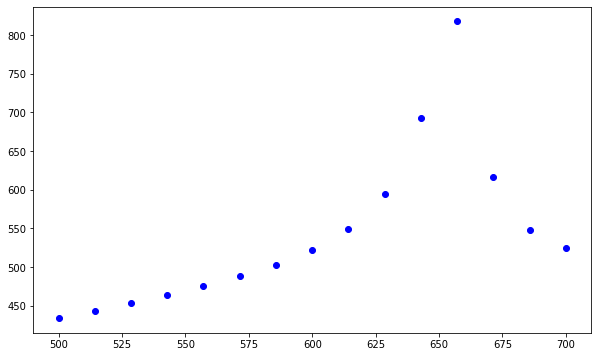

In [13]:
(pc, tc, rhoc) = gs1.critical_point(initial_t=380., v_nd=np.logspace(-3.5,-0.5,50), get_volume=False, get_density=True, print_results=False, print_progress=False)
print('{:25s}{:6.3f}'.format('Critical Pressure (MPa): ', pc/1e6))
print('{:25s}{:6.3f}'.format('Critical Temperature (K): ', tc))
print('{:25s}{:6.3f}'.format('Critical Density (mol/m3): ', rhoc))

trange = np.linspace(500,700,15)
vget = np.zeros(15)
cp = np.zeros(15)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for i in range(len(trange)):
    t = trange[i]
    vget[i] = gs1.single_phase_v(3e6, t, print_results=False, v_crit=1/rhoc, v_init=0.3/rhoc, supercritical=True)
    cp[i] = gs1.get_cp(temperature=t, molar_volume=vget[i])
    print('Cp at {:6.3f}K calculated to be {:6.3f}'.format(t, cp[i]))
    ax.plot(trange[i], cp[i], 'bo')